In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

# External library imports
import torch
import torch.nn as nn
import numpy as np
import random
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, random_split

# internal library imports
from dataset import DebrisStatePairsDataset
from model import UNet, ComplexCNN, LargeUNet, SimpleUNet
from train import TrainerPairs, CustomDebrisLoss
from util.setting_utils import set_seed




In [2]:
# Set the random seed for multiple libraries to ensure repeatability

set_seed(42)

In [3]:
# Parameters

root_dir = r'/home/tom/repos/dyna-landslide-surrogate/data'
checkpoint_dir = r'/home/tom/repos/dyna-landslide-surrogate/checkpoints'
batch_size = 32
split_proportions = (0.7, 0.15, 0.15)
epochs = 100

in_channels = 3  # Number of input channels (e.g., terrain, velocity, thickness)
out_channels = 2  # Number of output channels (e.g., next velocity, next thickness)

In [4]:
# Data set up

# Initialize dataset with scaling
dataset = DebrisStatePairsDataset(root_dir, array_size=256, apply_scaling=True)

# Split dataset into train, validation, and test sets and create dataloaders
train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)

# Compute scaling factors based on the train dataset, but only if scaling is applied
if dataset.apply_scaling:
    train_dataset = train_loader.dataset.dataset 
    dataset.compute_scaling_factors()

# Dataset stats
print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

Total dataset size: 55718
Train size: 39370, Validation size: 8016, Test size: 8332


In [5]:
# Model setup

models = [
    # {'model': ComplexCNN(), 'name': 'complex_cnn'}, 
    # {'model': LargeUNet(), 'name': 'large_unet'},
    {'model': UNet(in_channels=in_channels, out_channels=out_channels), 'name': 'unet_fulldata_pair_customloss0-66'}
]

In [6]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")

# Train each model
for model_info in models:
    
    model = model_info['model']

    # Check if multiple GPUs are available and wrap the model using nn.DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        # This will wrap the model for use with multiple GPUs
        model = torch.nn.DataParallel(model)
    
    # Move model to the appropriate device
    model.to(device)
    
    # Define the loss function and optimizer
    # criterion = nn.MSELoss()
    # criterion = nn.L1Loss()
    criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    # Initialize the trainer
    model_name = model_info['name']
    trainer = TrainerPairs(model, optimizer, criterion, device, model_name=model_name, checkpoint_dir=checkpoint_dir)
    
    # Train the model
    print(f"Training {model_name}...")
    trainer.train(train_loader, val_loader, epochs=epochs, checkpoint_interval=5)
    
    print(f"Finished training {model_name}.")

Training on device: cuda.
Using 2 GPUs!
Training unet_fulldata_pair_customloss0-66...


Plotting losses...
Loss plot saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/unet_test/loss_plot.png


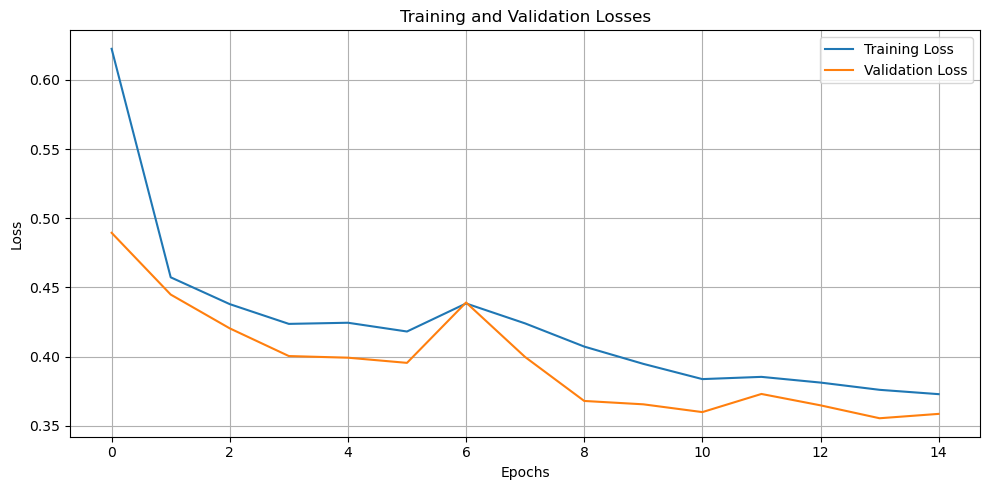

In [ ]:
# Evaluate the model on the test set
print("Plotting losses...")
trainer.plot_losses()

In [ ]:
# Evaluate the model on the test set
print("Evaluating the model on the test set...")
trainer.test(test_loader)


Evaluating the model on the test set...
Test Loss: 0.5159


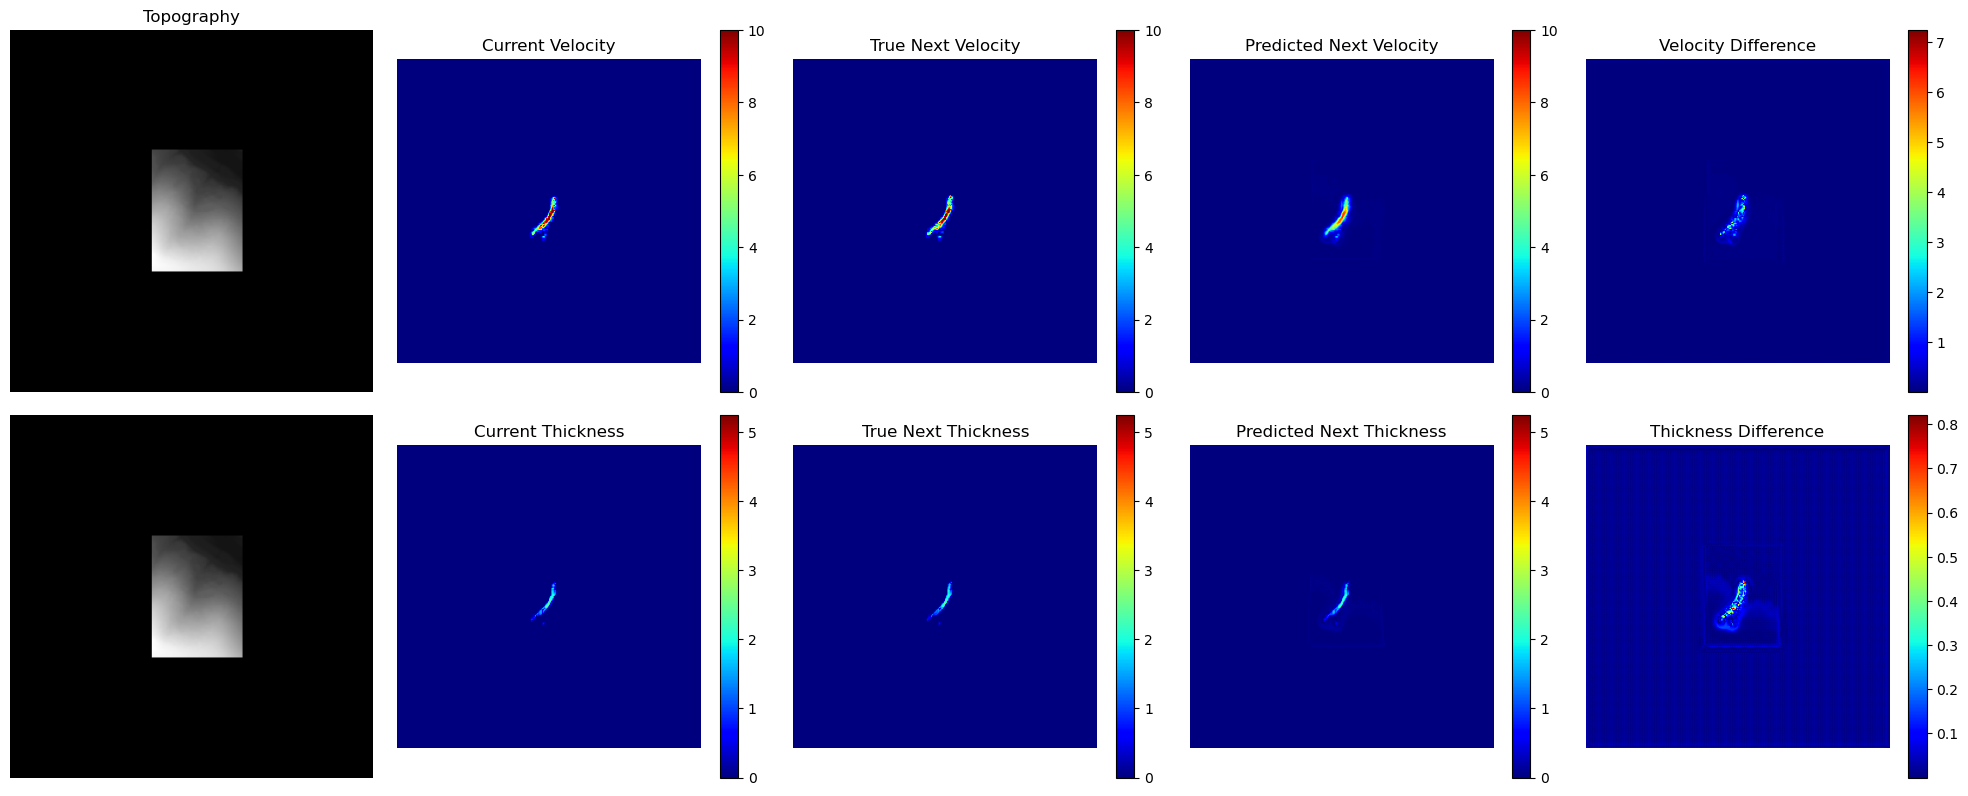

In [ ]:
trainer.plot_predictions(test_loader, num_predictions=1)